<a href="https://colab.research.google.com/github/LuccaNolasco/Convolutional-Neural-Network-RESTIC/blob/main/Rede_Neural_de_Classifica%C3%A7%C3%A3o_Unidade_10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Rede Neural Convolucional
O objetivo desse notebook é o desenvolvimento de um modelo capaz de classificar imagens de rostos entre "sexo masculino" e "sexo feminino", com o desafio de ser uma base de dados desbalanceada

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import f1_score, roc_curve, auc, accuracy_score,precision_score, recall_score, roc_auc_score
import numpy as np
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Model

### Baixando dados do Kaggle e listando

In [ ]:
!pip install kaggle
!kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs --force
!unzip -oq "cuhk-face-sketch-database-cufs.zip"

def list_files_in_folder(folder_path):
  """Lists all files in a given folder."""
  try:
    file_list = os.listdir(folder_path)
    return file_list
  except FileNotFoundError:
    print(f"Error: Folder not found at {folder_path}")
    return []

photos_folder = "photos"
files_in_photos = list_files_in_folder(photos_folder)

Dataset URL: https://www.kaggle.com/datasets/arbazkhan971/cuhk-face-sketch-database-cufs
License(s): copyright-authors
 80% 91.0M/113M [00:00<00:00, 227MB/s]
100% 113M/113M [00:00<00:00, 189MB/s] 


In [ ]:
print(files_in_photos)
print(len(files_in_photos))

['m1-011-01.jpg', 'm-039-01.jpg', 'm-065-01.jpg', 'm1-037-01.jpg', 'm-044-01.jpg', 'f1-004-01.jpg', 'm1-039-01.jpg', 'm-038-01.jpg', 'm-099-01.jpg', 'm1-005-01.jpg', 'm-016-01.jpg', 'm1-007-01.jpg', 'm-073-01.jpg', 'f-043-01.jpg', 'f-010-01.jpg', 'm-015-01.jpg', 'm-085-01.jpg', 'm-034-01.jpg', 'm1-028-01.jpg', 'm-049-01.jpg', 'm-091-01.jpg', 'm1-036-01.jpg', 'm-018-01.jpg', 'm-077-01.jpg', 'f-033-01.jpg', 'm-097-01.jpg', 'm-095-01.jpg', 'm-031-01.jpg', 'f-027-01.jpg', 'm-027-01.jpg', 'm-025-01.jpg', 'f-018-01.jpg', 'f1-011-01.jpg', 'f-024-01.jpg', 'm-089-01.jpg', 'f1-012-01.jpg', 'm-096-01.jpg', 'f-026-01.jpg', 'm1-023-01.jpg', 'm-041-01.jpg', 'f-039-01.jpg', 'm-010-01.jpg', 'f1-007-01.jpg', 'm-071-01.jpg', 'f1-001-01.jpg', 'm1-017-01.jpg', 'm-069-01.jpg', 'f-008-01.jpg', 'm-014-01.jpg', 'm-075-01.jpg', 'f1-010-01.jpg', 'm-052-01.jpg', 'm-061-01.jpg', 'm-019-01.jpg', 'f-022-01.jpg', 'm1-024-01.jpg', 'm-050-01.jpg', 'm-029-01.jpg', 'm1-038-01.jpg', 'f-005-01.jpg', 'm-037-01.jpg', 'm1-01

# 📋 Rotulando as Imagens
Inicialmente, pensamos em rotular manualmente as imagens. Porém, vimos que fotos de homens começam com "m", e de mulheres com "f". Logo, achamos a abordagem de percorrer os arquivos mais prática.

In [ ]:


def classificaImagem(folder_path):
    """Classifica as imagens automaticamente com base na primeira letra do nome do arquivo."""

    # Lista os arquivos na pasta
    files = os.listdir(folder_path)

    # Armazenar os resultados
    results = []

    # Iterar sobre os arquivos
    for file in files:
        # Verificar se o nome do arquivo começa com 'm' ou 'M' (masculino)
        if file[0].lower() == 'm':
            sex = 0
        # Verificar se o nome do arquivo começa com 'f' ou 'F' (feminino)
        elif file[0].lower() == 'f':
            sex = 1
        else:
            # Se o nome não começar com 'm' ou 'f', pode-se definir uma classificação como "indefinido"
            # ou simplesmente ignorar (dependendo do caso)
            sex = 'indefinido'

        # Adicionar o resultado à lista
        results.append({'filename': file, 'sex': sex})

    # Converter os resultados para um DataFrame
    df = pd.DataFrame(results)

    return df

# Usar a função para classificar as imagens
photos_folder = "photos"  # Substitua pelo caminho correto da sua pasta de fotos
df = classificaImagem(photos_folder)

# Exibir as primeiras linhas do DataFrame
df.head()

,filename,sex
0,m1-011-01.jpg,0
1,m-039-01.jpg,0
2,m-065-01.jpg,0
3,m1-037-01.jpg,0
4,m-044-01.jpg,0


## 🤳 Função para abrir imagem

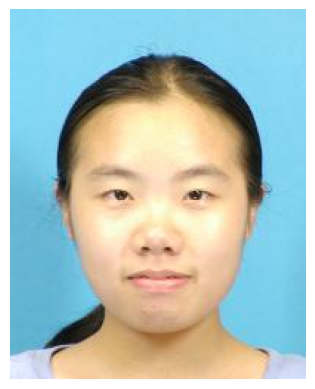

In [ ]:
def abreImagem(df, index, folder_path):
    """Abre a imagem localizada na posição 'index' do DataFrame."""

    # Pegar o nome do arquivo da imagem na posição 'index'
    file_name = df.iloc[index]['filename']

    # Construir o caminho completo para o arquivo
    file_path = os.path.join(folder_path, file_name)

    # Carregar a imagem
    img = mpimg.imread(file_path)

    # Exibir a imagem
    plt.imshow(img)
    plt.axis('off')  # Remover os eixos
    plt.show()

# Usar a função para abrir a imagem na posição 2 (por exemplo)
index = 187  # Altere para o índice que você deseja acessar
abreImagem(df, index, photos_folder)

## 🏗 Pré-Processamento das imagens
Aqui, redimensionamos as iamgens para que possuam 200x250 pixels (Largura x Altura), e normalizamos seus valores rgb. Já transformamos as imagems em arrays Pandas, e adicionamos essa coluna ao dataFrame

        filename  sex                                        image_array
0  m1-011-01.jpg    0  [[[0.00392156862745098, 0.0, 0.0], [0.00392156...
1   m-039-01.jpg    0  [[[0.0, 0.06666666666666667, 0.137254901960784...
2   m-065-01.jpg    0  [[[0.4, 0.7411764705882353, 0.8588235294117647...
3  m1-037-01.jpg    0  [[[0.0, 0.00392156862745098, 0.0], [0.0, 0.003...
4   m-044-01.jpg    0  [[[0.00392156862745098, 0.00784313725490196, 0...


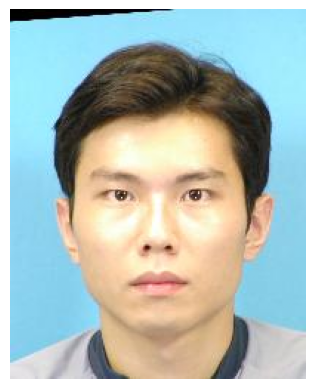

In [ ]:
def dimensaoENormalizacao(df, folder_path, target_size=(200, 250)):
    """
    Faz o pré-processamento da imagem para redimensionar e normalizar o RGB.

    Parameters:
    df (pd.DataFrame): Datafrane que contem "filename" e "sex"
    folder_path (str): Caminho para o diretório que contem as imagens.
    target_size (tuple): Dimensões alvo de largura x altura.

    Returns:
    pd.DataFrame: Um dataframe atualizada com uma nova coluna, de um array já normalizado.
    """
    processed_data = []

    for index, row in df.iterrows():
        file_name = row['filename']
        sex = row['sex']
        file_path = os.path.join(folder_path, file_name)

        try:
            # Abre a imagem
            with Image.open(file_path) as img:
                # Redimensiona
                img_resized = img.resize(target_size)
                # Convert para um array Numpy e normaliza
                img_array = np.array(img_resized) / 255.0
                # Junta a um novo DF
                processed_data.append({'filename': file_name, 'sex': sex, 'image_array': img_array})
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

    # Cria o DF novo
    processed_df = pd.DataFrame(processed_data)

    return processed_df

# Processa a imagem e cria um novo dataframe
processed_df = dimensaoENormalizacao(df, photos_folder)

print(processed_df.head())

plt.imshow(processed_df.iloc[0]['image_array'])
plt.axis('off')
plt.show()

# Dividindo os Dados
Aqui, criamos uam função que irá dividir os dados em três: treino, validação e testes, respeitando a proporção proposta e a seed indicada.

In [ ]:
def split_dataset(df, train_ratio=0.5, val_ratio=0.3, test_ratio=0.2, seed=23):
    """
    Divide o dataset em conjuntos de treinamento, validação e teste.

    Parâmetros:
    - df (pd.DataFrame): DataFrame contendo os dados.
    - train_ratio (float): Proporção para o conjunto de treinamento.
    - val_ratio (float): Proporção para o conjunto de validação.
    - test_ratio (float): Proporção para o conjunto de teste.
    - seed (int): Semente para replicabilidade.

    Retorna:
    - df_train, df_val, df_test: DataFrames para treino, validação e teste.
    """
    assert train_ratio + val_ratio + test_ratio == 1.0, "As proporções devem somar 1.0"

    # Divisão inicial: treino + validação e teste
    df_train_val, df_test = train_test_split(df, test_size=test_ratio, random_state=seed)

    # Ajustar proporção relativa de validação em relação ao conjunto treino + validação
    relative_val_ratio = val_ratio / (train_ratio + val_ratio)

    # Dividir treino e validação
    df_train, df_val = train_test_split(df_train_val, test_size=relative_val_ratio, random_state=seed)

    return df_train, df_val, df_test

# Dividir o DataFrame preprocessado
df_train, df_val, df_test = split_dataset(processed_df)

# Exibir o número de exemplos em cada conjunto
print(f"Treinamento: {len(df_train)} exemplos")
print(f"Validação: {len(df_val)} exemplos")
print(f"Teste: {len(df_test)} exemplos")

Treinamento: 93 exemplos
Validação: 57 exemplos
Teste: 38 exemplos


## 🏠 Definição da arquitetura Inicial.

Através dessa função, definimos a arquitetura inicial do modelo. Essa função passará por muitas alterações após o treino e a verificação das métricas.

No modelo final, utilizamos outra arquitetura, mas optamos por manter essa função pois a comparação entre duas trouxe insights interessantes sobre a quantidade de parâmetros e o uso da flatten

In [ ]:
def create_cnn_model(input_shape):
    """
    Cria uma arquitetura CNN personalizada para classificação binária.

    Parâmetros:
    - input_shape (tuple): Dimensões das imagens de entrada (altura, largura, canais).

    Retorna:
    - Modelo compilado do Keras.
    """
    model = models.Sequential()

    # 1ª camada convolucional
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    # 2ª camada convolucional
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    # 3ª camada convolucional (se necessário)
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    # Flatten + Fully Connected
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))  # Menor número de unidades
    model.add(layers.Dropout(0.5))  # Regularização
    model.add(layers.Dense(1, activation='sigmoid'))  # Saída binária

    # Compilação do modelo
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Criar o modelo
input_shape = (200, 250, 3)  # Largura, altura, canais (RGB)
model = create_cnn_model(input_shape)

# Exibir o resumo da arquitetura
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 198, 248, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 99, 124, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 99, 124, 16)         │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 97, 122, 32)         │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 61, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 61, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 59, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 23, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 42688)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       1,366,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,390,113 (5.30 MB)

 Trainable params: 1,389,889 (5.30 MB)

 Non-trainable params: 224 (896.00 B)

Sepando os dataframes

In [ ]:
# Separando df_train em X_train e y_train
X_train = np.stack(df_train['image_array'].values)  # Converte para array com formato correto
y_train = df_train['sex']  # Rótulo de saída (coluna 'sex')

# Separando df_val em X_val e y_val
X_val = np.stack(df_val['image_array'].values)  # Converte para array com formato correto
y_val = df_val['sex']  # Rótulo de saída (coluna 'sex')

# Separando df_test em X_test e y_test
X_test = np.stack(df_test['image_array'].values)  # Converte para array com formato correto
y_test = df_test['sex']  # Rótulo de saída (coluna 'sex')

# Verificando as formas para garantir que está tudo correto
print(f"Forma do X_train: {X_train.shape}")
print(f"Forma do y_train: {y_train.shape}")
print(f"Forma do X_val: {X_val.shape}")
print(f"Forma do y_val: {y_val.shape}")
print(f"Forma do X_test: {X_test.shape}")
print(f"Forma do y_test: {y_test.shape}")

Forma do X_train: (93, 250, 200, 3)
Forma do y_train: (93,)
Forma do X_val: (57, 250, 200, 3)
Forma do y_val: (57,)
Forma do X_test: (38, 250, 200, 3)
Forma do y_test: (38,)


## 😵 Classes desbalanceadas
Iremos adicionar peso ao treinamento numa tentativa inicial de compensar sem adicionar mais dados

In [ ]:
# Contar o número de tuplas com 'sex' igual a 0
count_0 = (processed_df['sex'] == 0).sum()

# Contar o número de tuplas com 'sex' igual a 1
count_1 = (processed_df['sex'] == 1).sum()

# Exibir os resultados
print(f'Número de tuplas com "sex" igual a 0: {count_0}')
print(f'Número de tuplas com "sex" igual a 1: {count_1}')

Número de tuplas com "sex" igual a 0: 134
Número de tuplas com "sex" igual a 1: 54


Epoch 1/20
3/3 - 20s - 7s/step - accuracy: 0.5699 - loss: 3.3883 - val_accuracy: 0.2807 - val_loss: 0.9370
Epoch 2/20
3/3 - 15s - 5s/step - accuracy: 0.6559 - loss: 2.3613 - val_accuracy: 0.2807 - val_loss: 1.3830
Epoch 3/20
3/3 - 8s - 3s/step - accuracy: 0.8602 - loss: 0.8934 - val_accuracy: 0.2807 - val_loss: 1.9348
Epoch 4/20
3/3 - 7s - 2s/step - accuracy: 0.8710 - loss: 0.5795 - val_accuracy: 0.2807 - val_loss: 2.1235
Epoch 5/20
3/3 - 5s - 2s/step - accuracy: 0.8710 - loss: 0.2817 - val_accuracy: 0.2807 - val_loss: 2.0786
Epoch 6/20
3/3 - 5s - 2s/step - accuracy: 0.8925 - loss: 0.3853 - val_accuracy: 0.2807 - val_loss: 1.4728


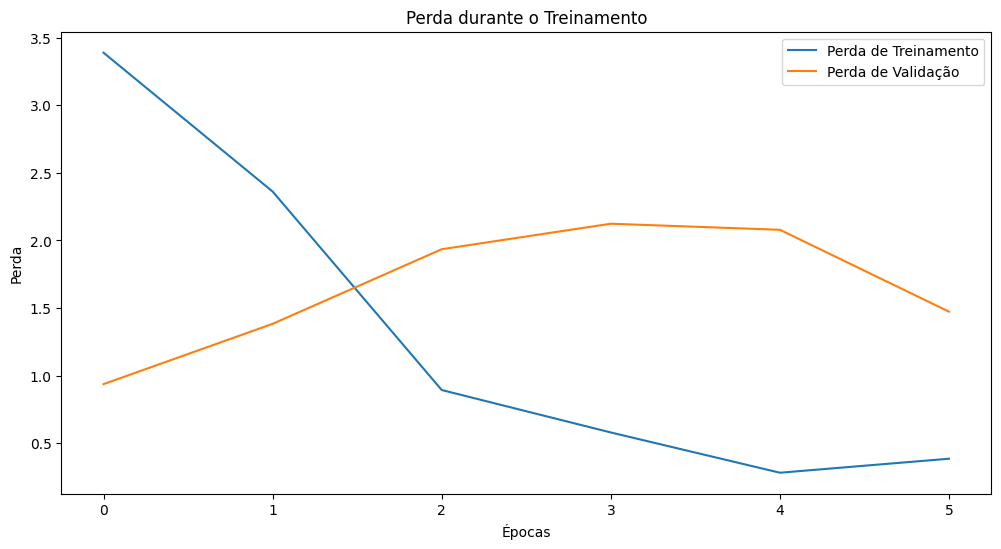

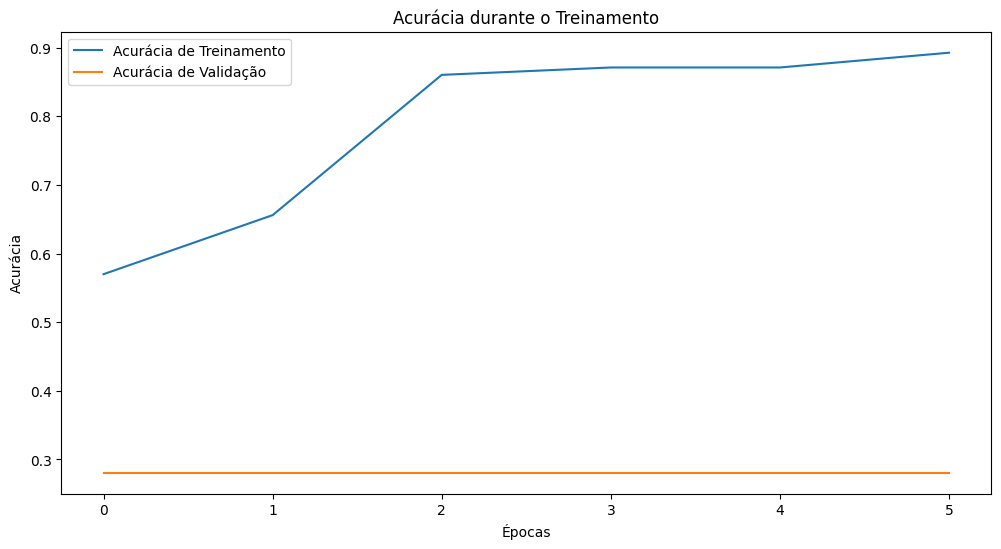

In [ ]:
# Definir o modelo
model = create_cnn_model(input_shape=(200, 250, 3))  # Assumindo que o input_shape é (200, 250, 3)

# Configurar o EarlyStopping para evitar overfitting e monitorar a validação
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Equilibrando
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.array([0, 1]),
    y=y_train
)


# Convertê-los para o formato esperado pelo Keras
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

y_train = y_train.to_numpy()


# Treinamento do modelo
history = model.fit(
    X_train, y_train,  # Dados de treino
    epochs=20,  # Número de épocas
    batch_size=32,  # Tamanho do lote
    validation_data=(X_val, y_val),  # Dados de validação
    callbacks=[early_stopping],  # Usando EarlyStopping para monitorar o desempenho
    verbose=2,  # Detalhamento do progresso
    class_weight=class_weight_dict
)

# Exibir resumo do treinamento
#model.summary()

# Gráficos de desempenho durante o treinamento
import matplotlib.pyplot as plt

# Gráfico de perda de treino e validação
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

# Gráfico de acurácia de treino e validação
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
F1-Score: 0.5098039215686274
Acurácia: 0.34210526315789475
Precisão: 0.34210526315789475
AUC-ROC: 0.5230769230769231


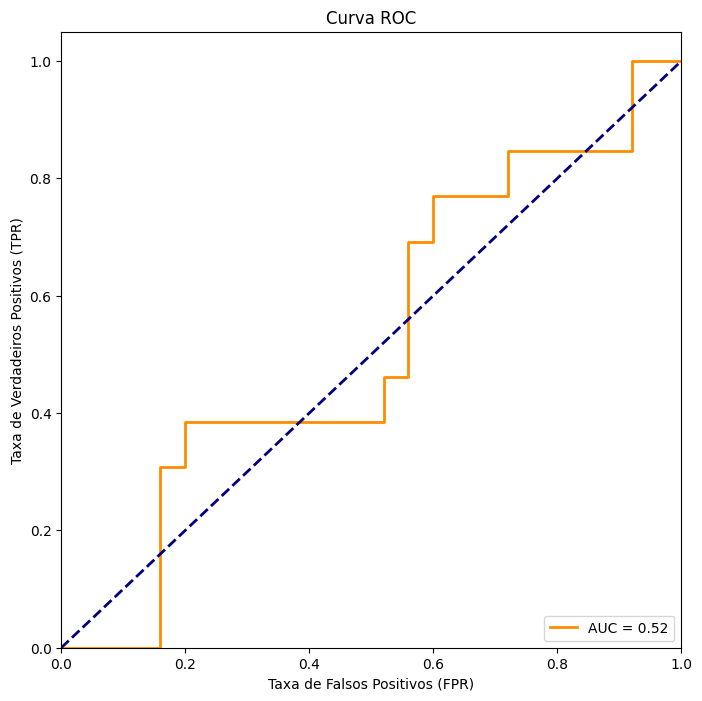

In [ ]:
# Prever com o modelo no conjunto de teste
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convertendo probabilidades para classes binárias

# 1. F1-Score, Accuracy, Precision
f1 = f1_score(y_test, y_pred_classes)
print(f"F1-Score: {f1}")
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Acurácia: {accuracy}")
precision = precision_score(y_test, y_pred_classes)
print(f"Precisão: {precision}")



# 2. Curva ROC e AUC-ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)  # Falsos positivos, verdadeiros positivos, thresholds
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc}")

# Gráfico da Curva ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Linha diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()



## Baixo F1 - Score aponta o desequilibrio
Buscamos então um "limiar ótimo", numa tentativa de melhoria do modelo, mas como demonstram as métricas posteriores, o resultado continuou insatisfatório


In [ ]:
y_pred_prob = model.predict(X_test)  # Previsões de probabilidade
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Limiar ótimo: {optimal_threshold}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
Limiar ótimo: 0.7050656676292419


In [ ]:
# Aplicar o limiar ótimo
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# Recalcular as métricas
f1_optimal = f1_score(y_test, y_pred_optimal)
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
precision_optimal = precision_score(y_test, y_pred_optimal)
recall_optimal = recall_score(y_test, y_pred_optimal)
auc_roc_optimal = roc_auc_score(y_test, y_pred_prob)  # AUC permanece o mesmo porque usa probabilidades

# Exibir os resultados
print(f"F1-Score com limiar ótimo: {f1_optimal}")
print(f"Acurácia com limiar ótimo: {accuracy_optimal}")
print(f"Precisão com limiar ótimo: {precision_optimal}")
print(f"Recall com limiar ótimo: {recall_optimal}")
print(f"AUC-ROC: {auc_roc_optimal}")

F1-Score com limiar ótimo: 0.43478260869565216
Acurácia com limiar ótimo: 0.6578947368421053
Precisão com limiar ótimo: 0.5
Recall com limiar ótimo: 0.38461538461538464
AUC-ROC: 0.5230769230769231


##👨‍💻 Geração de Imagens para a classe minoritária
O desequilíbrio refletiu em métricas terríveis para o modelo. Mesmo com a alteração no limiar e nos pesos. Optamos por criar imagens novas. Selecionamos imagens da classe minoritária e alteramos o ângulo de inclinação em certo intervalo, a proporção de largura e altura, o zoom, o brilho, preenchemos alguns pixels (ruído) e viramos a imagem horizontalmente.

Após isso, normalizamos as imagens e redimensionamos

In [ ]:
# Filtrar as imagens de mulheres do DataFrame
women_images = np.array([row['image_array'] for idx, row in processed_df.iterrows() if row['sex'] == 1])

# Verificar o formato das imagens originais
print(f"Formato das imagens originais: {women_images.shape}")

# Criar o gerador de aumento de dados
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Ajustar o gerador para as imagens de mulheres
datagen.fit(women_images)

augmented_images = []
num_images_to_generate = 80  # Número de imagens que queremos gerar

# Gerar as imagens até atingirmos 80
for image_batch in datagen.flow(women_images, batch_size=1):
    augmented_images.append(image_batch[0])  # Adiciona a imagem gerada
    if len(augmented_images) >= num_images_to_generate:  # Parar após gerar 80 imagens
        break

# Converte a lista para um array NumPy
augmented_images = np.array(augmented_images)

# NORMALIZAÇÃO das imagens aumentadas (mesma abordagem do código original)
augmented_images = augmented_images / 255.0  # Normaliza as imagens aumentadas

# Verifique a forma do resultado
print(f"Formato das imagens aumentadas: {augmented_images.shape}")

Formato das imagens originais: (54, 250, 200, 3)
Formato das imagens aumentadas: (80, 250, 200, 3)


## Concatenação dos dataframes, para um equilíbrio entre as classes

In [ ]:
# Criar um dataframe para as imagens aumentadas
augmented_df = pd.DataFrame({
    'filename': [f"augmented_{i}.jpg" for i in range(augmented_images.shape[0])],  # Criando nomes fictícios para as imagens
    'sex': [1] * augmented_images.shape[0],  # Como as imagens aumentadas são de mulheres, atribuímos 1 para 'sex'
    'image_array': list(augmented_images)  # Lista das imagens aumentadas
})

# Concatenar o dataframe original com o dataframe das imagens aumentadas
processed_df_combined = pd.concat([processed_df, augmented_df], ignore_index=True)

# Verificar a concatenação (opcional)
print(processed_df_combined.head())

# Contar quantos homens e mulheres existem no dataframe resultante
sex_counts = processed_df_combined['sex'].value_counts()

# Exibir o número de homens e mulheres
print(f"Homens: {sex_counts.get(0, 0)}")
print(f"Mulheres: {sex_counts.get(1, 0)}")

        filename  sex                                        image_array
0  m1-011-01.jpg    0  [[[0.00392156862745098, 0.0, 0.0], [0.00392156...
1   m-039-01.jpg    0  [[[0.0, 0.06666666666666667, 0.137254901960784...
2   m-065-01.jpg    0  [[[0.4, 0.7411764705882353, 0.8588235294117647...
3  m1-037-01.jpg    0  [[[0.0, 0.00392156862745098, 0.0], [0.0, 0.003...
4   m-044-01.jpg    0  [[[0.00392156862745098, 0.00784313725490196, 0...
Homens: 134
Mulheres: 134


## 🧑👩Dividimos os conjuntos de Treino, Validação e Teste
Aqui, fazemos a divisão com as proporções e a seed desejada. Além disso, utilizamos estratificação para garantir que a quantidade de homens e mulheres em cada um desses 3 conjuntos seja equivalente

In [ ]:
# Transformando a coluna 'image_array' em um array NumPy
X_images = np.array([np.array(image) for image in processed_df_combined['image_array']])

# Dividir os dados em treino e teste (20%) com estratificação pela classe
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_images,  # Agora X_images contém as imagens
    processed_df_combined['sex'],
    test_size=0.2,
    stratify=processed_df_combined['sex'],
    random_state=23
)

# Dividir os dados de treino/validação em treino (50% dos dados originais) e validação (30% dos dados originais)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.375,  # Isso vai garantir que a validação tenha 30% dos dados originais
    stratify=y_train_val,
    random_state=23
)

# Verificar a distribuição dos dados em cada conjunto
print("Distribuição dos dados:")
print(f"Treinamento: {y_train.value_counts()}")
print(f"Validação: {y_val.value_counts()}")
print(f"Teste: {y_test.value_counts()}")


Distribuição dos dados:
Treinamento: sex
0    67
1    66
Name: count, dtype: int64
Validação: sex
1    41
0    40
Name: count, dtype: int64
Teste: sex
1    27
0    27
Name: count, dtype: int64


## 💪 A nova Arquitetura
Buscamos nessa nova arquitetura um modelo mais potente: ele possui mais profundidade e mais filtros por camada. Além disso, para evitar overfitting, usamos Global Average Pooling ao invés de Flatten, o que reduziu drasticamente (em quase 3x) a quantidade de parâmetros.

In [ ]:
def create_enhanced_cnn_model(input_shape):
    model = models.Sequential()

    # 1ª camada convolucional
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    # 2ª camada convolucional
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    # 3ª camada convolucional
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    # 4ª camada convolucional (para mais abstração)
    model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    # Global Average Pooling (melhor que Flatten em alguns casos)
    model.add(layers.GlobalAveragePooling2D())

    # Camada totalmente conectada
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(layers.Dropout(0.5))  # Regularização com dropout

    # Camada de saída
    model.add(layers.Dense(1, activation='sigmoid'))  # Saída binária

    # Compilação do modelo
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model



# Criar o modelo
input_shape = (200, 250, 3)  # Altura, largura, canais (RGB)
modelo2 = create_enhanced_cnn_model(input_shape)

modelo2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 198, 248, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 99, 124, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 99, 124, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 97, 122, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 48, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 48, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 46, 59, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 23, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 23, 29, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 21, 27, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 10, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 10, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 423,361 (1.61 MB)

 Trainable params: 422,401 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
history = modelo2.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step - accuracy: 0.6645 - loss: 5.2941 - val_accuracy: 0.5432 - val_loss: 5.2194
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.8508 - loss: 4.8969 - val_accuracy: 0.7778 - val_loss: 4.9144
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.8228 - loss: 4.6468 - val_accuracy: 0.5062 - val_loss: 4.6488
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.8590 - loss: 4.3375 - val_accuracy: 0.7778 - val_loss: 4.3891
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.8619 - loss: 4.0533 - val_accuracy: 0.7778 - val_loss: 4.1215
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8468 - loss: 3.7768 - val_accuracy: 0.7778 - val_loss: 3.8611
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - accuracy: 0.8481 - loss: 3.5188 - val_accuracy: 0.7778 - val_loss: 3.6199
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.9114 - loss: 3.2879 - val_accuracy: 0.5679 - val_loss: 3.4407
Epoch 9/

## Métricas e Curva ROC
Boas métricas. O F1-Score sugere que o modelo está equilibrado, e a AUC mostra que está robusto.

2/2 - 3s - 1s/step - accuracy: 0.8704 - loss: 1.8223
Loss no teste: 1.8223
Acurácia no teste: 0.8704


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 811ms/step


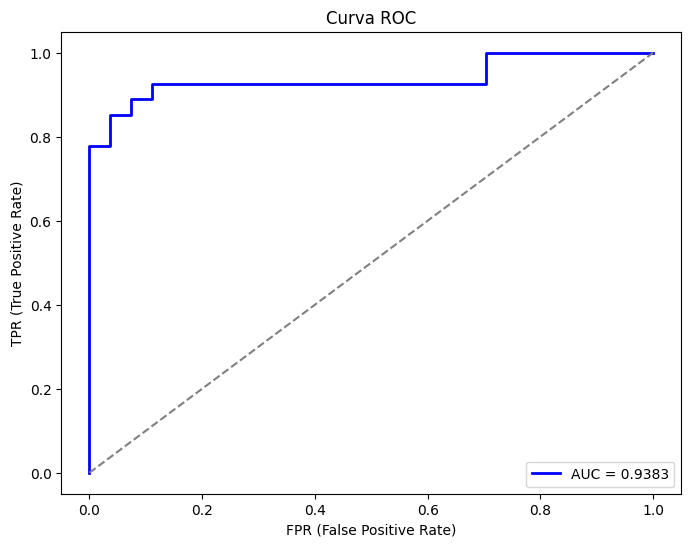

Precision: 1.0000
Recall: 0.7407
F1-Score: 0.8511
AUC-ROC: 0.9383


In [ ]:
# Avaliar o modelo no conjunto de teste
test_loss, test_acc = modelo2.evaluate(X_test, y_test, verbose=2)
print(f'Loss no teste: {test_loss:.4f}')
print(f'Acurácia no teste: {test_acc:.4f}')


# Obter as predições do modelo
y_pred_prob = modelo2.predict(X_test)  # Predição de probabilidade
y_pred = (y_pred_prob > 0.5).astype(int)  # Convertendo para 0 ou 1 (binário)

# Calculando Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculando a Curva ROC e AUC-ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_roc = auc(fpr, tpr)

# Plotando a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_roc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Exibir as métricas
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

## ✔ ✖ Matriz de Confusão
O modelo acertou completamente a classe 0 (o que indica sua precisão de 1.00), porém, classificou errôneamente 7 imagens da classe 1. Talvez devido à falta de amostras e a necessidade de adição artificial.

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 647ms/step


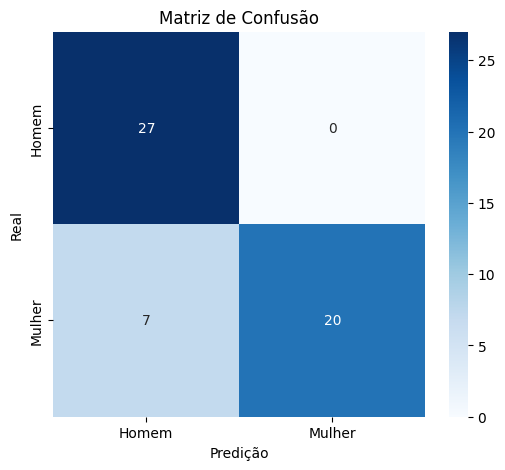

In [ ]:
# Fazer previsões no conjunto de teste
y_pred = modelo2.predict(X_test)

# Converter as probabilidades de saída para 0 ou 1 (para binária)
y_pred_classes = (y_pred > 0.5).astype(int)

# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_pred_classes)

# Exibir a matriz de confusão com o Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Homem', 'Mulher'], yticklabels=['Homem', 'Mulher'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## Comparação da Perda do Treino e Validação
Essa curva demonstra uma baixa chance de overfitting

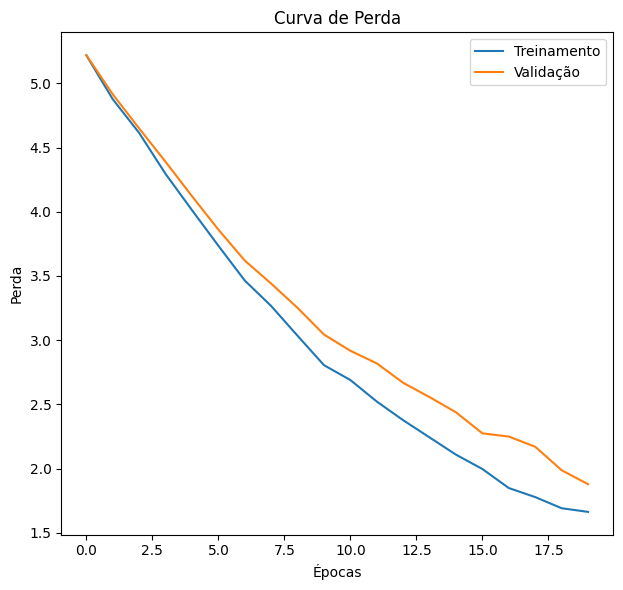

In [ ]:
# Curva de precisão durante o treino e validação
plt.figure(figsize=(12, 6))

# Curva de perda durante o treino e validação
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Curva de Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Exibir os gráficos
plt.tight_layout()
plt.show()

## Imagens Classificadas Incorretamente
6 das 7 imagens possuem uma forte iluminação frontal. A sétima, possui o topo da cabeça com formato arrendondado o que, como veremos no feature map, foi uma região muito avaliada pelo modelo.

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


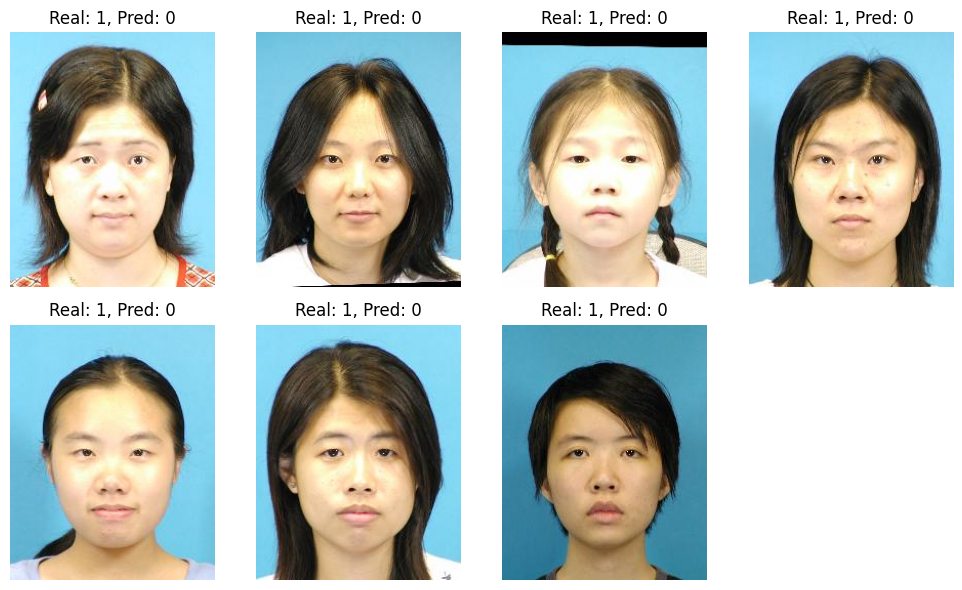

In [ ]:
# Obter as previsões no conjunto de teste
y_pred = modelo2.predict(X_test)

# Converter as previsões de probabilidade para rótulos binários
y_pred_labels = (y_pred > 0.5).astype(int)

# Converter y_test para um array 1D
y_test_values = y_test.values

# Encontrar as imagens previstas incorretamente
incorrect_indices = np.where(y_pred_labels.flatten() != y_test_values)[0]

# Exibir as 7 primeiras imagens incorretas
plt.figure(figsize=(10, 6))

for i, idx in enumerate(incorrect_indices[:7]):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_test[idx])  # Mostrar a imagem
    plt.title(f"Real: {y_test_values[idx]}, Pred: {y_pred_labels[idx][0]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Feature Map da Camada Mais profunda


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


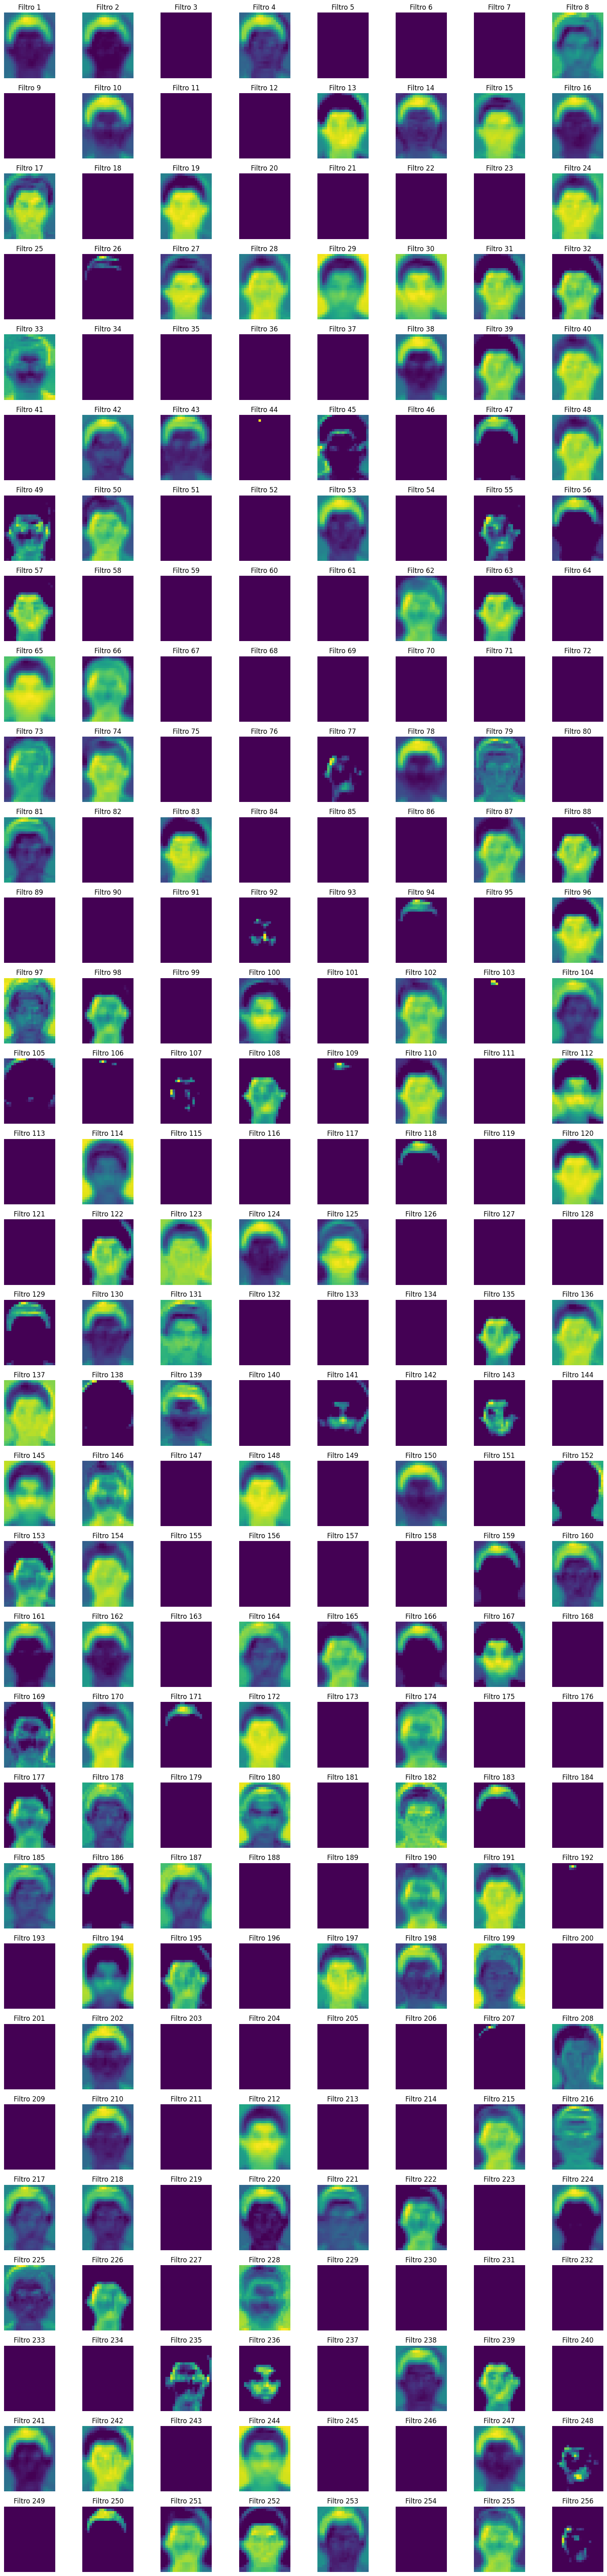

In [ ]:
# Função para carregar uma imagem do dataframe
def load_image_from_dataframe(index, dataframe):
    image_array = dataframe.iloc[index]['image_array']  # Acessa a imagem no dataframe
    image_array = np.expand_dims(image_array, axis=0)  # Adiciona a dimensão do batch
    return image_array

# Função para criar o modelo de ativações
def create_activation_model(model, layer_name):
    # Obter as ativações da camada específica
    layer_outputs = [layer.output for layer in model.layers if layer.name == layer_name]
    activation_model = Model(inputs=model.inputs, outputs=layer_outputs)
    return activation_model

# Função para plotar os feature maps
def plot_feature_map(activation, num_columns=8):
    num_filters = activation.shape[-1]  # Número de filtros na camada
    num_rows = num_filters // num_columns  # Número de linhas do gráfico

    plt.figure(figsize=(num_columns * 2, num_rows * 2))

    for i in range(num_filters):
        plt.subplot(num_rows, num_columns, i + 1)
        # Transpor a ativação se necessário (se estiver de lado)
        plt.imshow(np.transpose(activation[:, :, i]), cmap='viridis')  # Ignorar a primeira dimensão (batch_size)
        plt.axis('off')
        plt.title(f'Filtro {i + 1}')

    plt.tight_layout()
    plt.show()

# Usar uma imagem do dataframe (exemplo: índice 0 em X_test)
index = 15  # Substitua com o índice desejado
image_array = load_image_from_dataframe(index, processed_df)  # Carregar a imagem do dataframe

# Garantir que a imagem tenha o formato correto (200, 250, 3)
if image_array.shape[1] != 200 or image_array.shape[2] != 250:
    image_array = np.transpose(image_array, (0, 2, 1, 3))  # Corrigir a transposição

# Criar o modelo de ativações para a camada desejada
activation_model = create_activation_model(modelo2, 'conv2d_13')

# Gerar as ativações para a imagem carregada
activations = activation_model.predict(image_array)

# Plotar os feature maps da camada convolucional desejada
plot_feature_map(activations[0])  # As ativações são retornadas como uma lista, então pegamos o primeiro elemento


##🍿 Conclusões
O modelo parece robusto e capaz de ser usado em aplicações onde esse tipo de reconhecimento se faz necessário. Porém, cremos que seria importante um novo treino, com um conjunto de dados mais completo: uma faixa etária mais ampla, mais ângulos e iluminações, presença ou ausência de pelos faciais...

Para uma análise mais profunda, verificar o Relatório na raiz desse projeto.